In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg
from numpy.linalg import norm


## Anscombe's quartet

Graph each of the datasets and see how the samples are distributed. Making a plot of the dataset is commonly an important step to visually analyze the samples. 

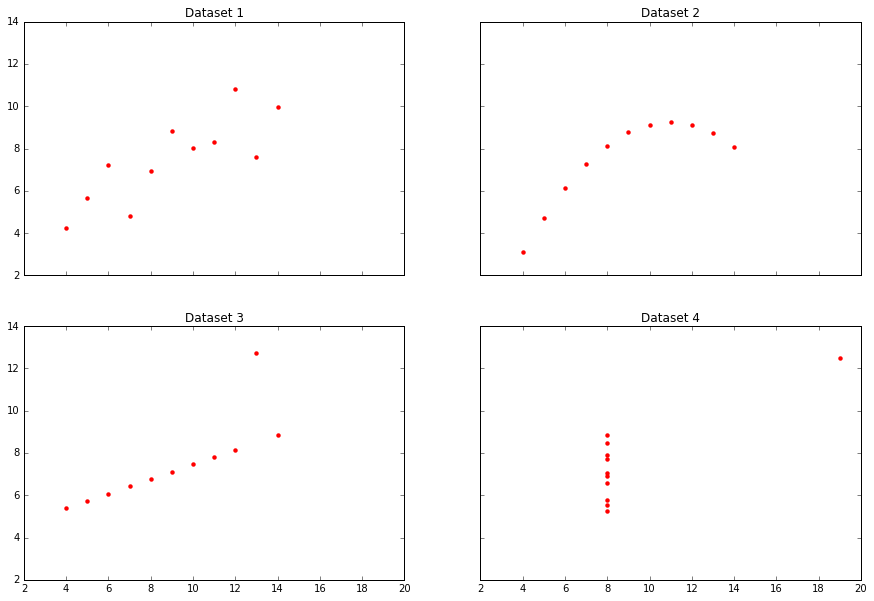

In [2]:
ds1 = np.loadtxt('Dataset/Anscombe/data_set1.txt')
ds2 = np.loadtxt('Dataset/Anscombe/data_set2.txt')
ds3 = np.loadtxt('Dataset/Anscombe/data_set3.txt')
ds4 = np.loadtxt('Dataset/Anscombe/data_set4.txt')

f,ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,10))  #Create a figure with a set of subplots already made.

ax[0, 0].scatter(ds1[:,:-1], ds1[:,1:], c = 'r',lw = 0)
ax[0, 1].scatter(ds2[:,:-1], ds2[:,1:], c = 'r',lw = 0)
ax[1, 0].scatter(ds3[:,:-1], ds3[:,1:], c = 'r',lw = 0)
ax[1, 1].scatter(ds4[:,:-1], ds4[:,1:], c = 'r',lw = 0)

ax[0, 0].set_title('Dataset 1')
ax[0, 1].set_title('Dataset 2')
ax[1, 0].set_title('Dataset 3')
ax[1, 1].set_title('Dataset 4')

# Error functions

- Least Square function
- Huber function
- Cauchy function

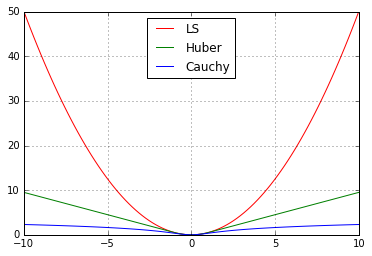

In [3]:
c=1.0
b=1.0
u = np.linspace(-10,10,100)   
p_ls = 1./2*u**2                                              # least squares function
p_rf = (abs(u)<=c)*(0.5*u**2)+(abs(u)>c)*((c*abs(u)-0.5*c))   # Huber function
p_cauchy = b**2/2.* np.log(1+(u/b)**2)                        # Cauchy function


plt.plot(u, p_ls,'r',label="LS")
plt.plot(u, p_rf,'g',label="Huber") 
plt.plot(u, p_cauchy,'b',label="Cauchy") 
plt.legend(loc=9)
plt.grid()

In [4]:
def plot(function, ds, col='b',label ='function'):
    x,y,yHat,A,history = function(ds)
    plt.plot(x,y,'ro')
    plt.plot(x,yHat,col,label = str(function)[9:16])
    plt.legend(loc=2)
    plt.xlim((0,20))
    plt.ylim((0,18))
    plt.grid()
    
def hist_plot(function, ds, col='b'):
    x,y,yHat,A,history = function(ds)
    plt.plot(x,yHat,col,label = str(function)[9:16])
    plt.legend(loc=2)
    plt.plot(x,y,'ro')
    for b in history: 
        yHat = np.dot(A,b)
        plt.plot(x,yHat,'b--')
    plt.plot(x,yHat,'r')
    plt.xlim((0,20))
    plt.ylim((0,18))
    plt.grid()
    
def fromDs(ds):
    x=np.array(ds[:,:-1])
    y=np.array(ds[:,1:] )
    n = x.shape[0]
    A = np.c_[np.ones((n,1)),x]   # concatenation along the 1st axis, i.e. adding a column of ones
    return (x,y,n,A)

### 1. Least Squarre

The least squares method has the advantage of having a closed solution. However,
the least squares method is known to be sensitive to outliers. The reason is
due to the fact that the least squares method minimizes the squared error which
may be very large for an outlier.

In [5]:
def leastSquare(ds):
    x,y,n,A = fromDs(ds)
    
    b = np.dot(numpy.linalg.inv(np.dot(A.T,A)), np.dot(A.T,y))
    history = [b]  # use in plot function
    yHat = np.dot(A,b)
    print "LS: b: %2s | LS Error %8f" %(b.ravel(), np.sum(abs(np.dot(A,b)-y)))
    
    return (x,y,yHat,A,history)

LS: b: [ 3.00009091  0.50009091] | LS Error 9.211455


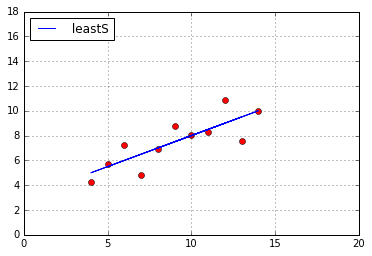

In [6]:
plot(leastSquare, ds1)

LS: b: [ 3.00090909  0.5       ] | LS Error 10.647273


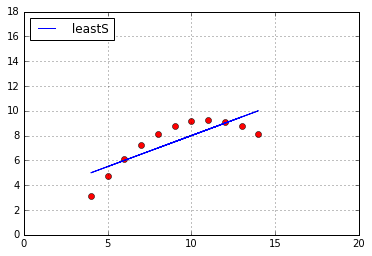

In [7]:
plot(leastSquare, ds2)

LS: b: [ 3.00245455  0.49972727] | LS Error 7.875636


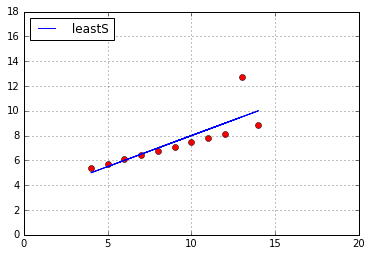

In [8]:
plot(leastSquare, ds3)

LS: b: [ 3.00172727  0.49990909] | LS Error 9.930000


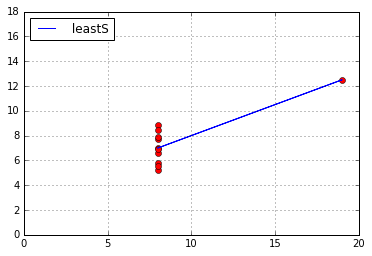

In [9]:
plot(leastSquare, ds4)

## Robust functions

### 2. Huber function

Observe that the Huber function is the least squared function if $ |u|\leq{c}$. For
$ |u| > c$  it is a function that does not square the error value and thus the outlier
won’t be given the same “importance” that is given by the least squares error.

In [10]:
def gradient(ds, b):
    x,y,n,A = fromDs(ds)
    e = np.dot(A,b)-y.T
    grad = np.array([np.sum((abs(e)<=c)*e) + np.sum((abs(e)>c)*(c*np.sign(e))), \
                np.sum((abs(e)<=c)*e) + np.sum((abs(e)>c)*(c*x*np.sign(e)))]) 
    return grad

In [11]:
def err_huber(ds, b):
    x,y,n,A = fromDs(ds)
    e = np.dot(A,b)-y.T
    Q = (abs(e)<=c)*(0.5*e**2)+(abs(e)>c)*((c*abs(e)-0.5*c**2))
    return np.sum(Q)

In [12]:
def Huber(ds, b0 = np.array([1.,1.]), c=1, alpha = 0.1, numIterations = 100, tol = 10**-5):
    x,y,n,A = fromDs(ds)
    
    it=0
    history = [b0] #  a list to store all b's
    
    while it < numIterations and abs(err_huber(ds, b0-alpha*gradient(ds,b0))-err_huber(ds, b0))>tol and alpha>10**-5:
        grad = gradient(ds,b0)
        b = b0 - alpha*grad
        
        if err_huber(ds, b)>= err_huber(ds, b0):
            alpha = alpha/2.
        else:   
            b0=b
            history.append(b0)
            it +=1   
            alpha =0.1

    print "\nHuber: Iteration %d | b: %s \nHuber Error: %f |LS Error:%f" % (it, b0 , err_huber(ds, b0), np.sum(abs(np.dot(A,b0)-y.T)))
    yHat = np.dot(A,b)
    return (x,y,yHat,A, history)


Huber: Iteration 2 | b: [ 0.99676103  0.70965165] 
Huber Error: 7.374439 |LS Error:11.859407


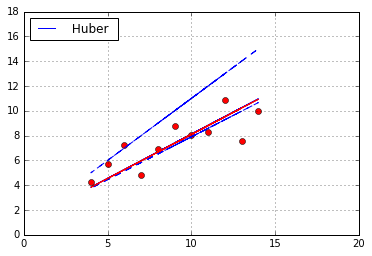

In [13]:
hist_plot(Huber, ds1)


Huber: Iteration 4 | b: [ 0.99720301  0.73880457] 
Huber Error: 7.221296 |LS Error:11.773931


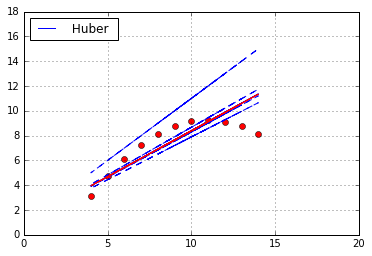

In [14]:
hist_plot(Huber, ds2)


Huber: Iteration 1 | b: [ 0.9965625  0.6903125] 
Huber Error: 7.190031 |LS Error:11.737500


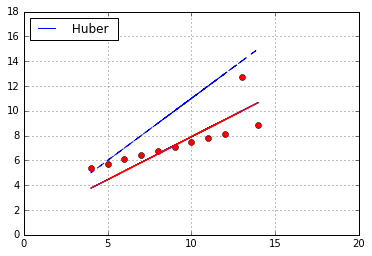

In [15]:
hist_plot(Huber, ds3)


Huber: Iteration 2 | b: [ 0.99650231  0.69025231] 
Huber Error: 7.689650 |LS Error:12.407213


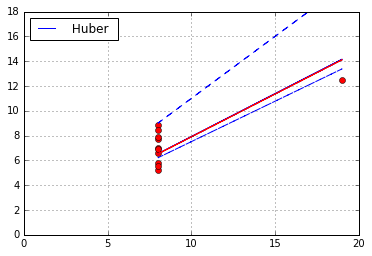

In [16]:
hist_plot(Huber, ds4)

### 3. Cauchy Function

The Cauchy function is even more robust to outliers than the Huber function.
However none of the three methods is able to fit correctly the dataset 4. 

In [17]:
def grad_cauchy(ds, b, bb=1):
    
    x,y,n,A = fromDs(ds)   
    e = np.dot(A,b)-y.T
    grad = np.array([np.sum((bb**2*e)/(bb**2 + e**2)),np.sum((bb**2*e*x.T)/(bb**2 + e**2))] ) 

    return grad


In [18]:
def err_cauchy(ds, b, bb=1):
    
    x,y,n,A = fromDs(ds) 
    e = np.dot(A,b)-y.T
    Q = bb**2/2.* np.log(1+(e/bb)**2) 

    return np.sum(Q)

In [19]:
def Cauchy(ds, b0 = np.array([1.,1.]), c=1, alpha = 0.1, numIterations = 800, tol = 10**-5):
    x,y,n,A = fromDs(ds)  
    
    it=0
    history = [b0] #  a list to store all b's
    
    while it < numIterations and alpha>10**-3 \
          and abs(err_cauchy(ds, b0-alpha*grad_cauchy(ds,b0))-err_cauchy(ds, b0))>tol:
        
        grad = grad_cauchy(ds,b0)
        b = b0 - np.dot(alpha,grad)
        
        if err_cauchy(ds, b)>= err_cauchy(ds, b0):
            alpha = alpha/2.
        else:   
            b0=b
            history.append(b0)
            it +=1   
            alpha =0.1

    print "\nCauchy: Iteration %d | b: %s  \nCauchy Error: %f | Huber Error: %f | LS Error:%f" % (it, b0 , err_cauchy(ds,b0), err_huber(ds, b0), np.sum(abs(np.dot(A,b0)-y.T)))
    yHat = np.dot(A,b)
    return (x,y,yHat,A, history)     


Cauchy: Iteration 236 | b: [ 2.24987247  0.57578238]  
Cauchy Error: 3.512743 | Huber Error: 6.003088 | LS Error:9.784345


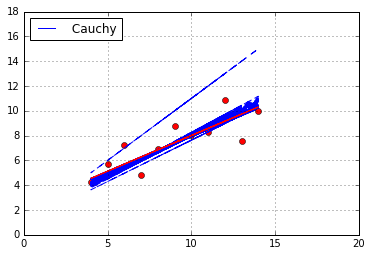

In [20]:
hist_plot(Cauchy, ds1)


Cauchy: Iteration 64 | b: [ 1.47775251  0.70694134]  
Cauchy Error: 3.907309 | Huber Error: 6.837367 | LS Error:11.291423


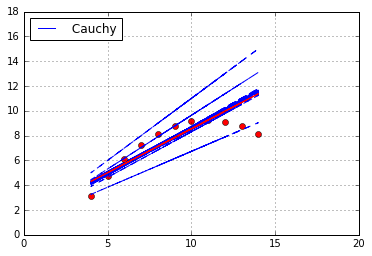

In [21]:
hist_plot(Cauchy, ds2)


Cauchy: Iteration 506 | b: [ 3.55625451  0.39686255]  
Cauchy Error: 1.542166 | Huber Error: 3.647202 | LS Error:5.362959


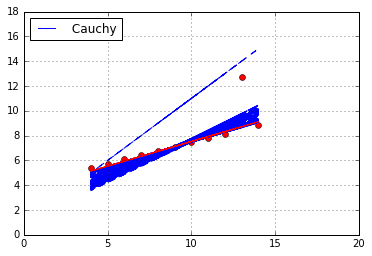

In [22]:
hist_plot(Cauchy, ds3)


Cauchy: Iteration 145 | b: [ 2.11357937  0.56420667]  
Cauchy Error: 3.860093 | Huber Error: 6.418021 | LS Error:10.789041


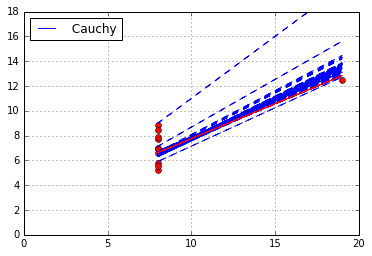

In [23]:
hist_plot(Cauchy, ds4)

# Compare the result

LS: b: [ 3.00009091  0.50009091] | LS Error 9.211455

Huber: Iteration 2 | b: [ 0.99676103  0.70965165] 
Huber Error: 7.374439 |LS Error:11.859407

Cauchy: Iteration 236 | b: [ 2.24987247  0.57578238]  
Cauchy Error: 3.512743 | Huber Error: 6.003088 | LS Error:9.784345


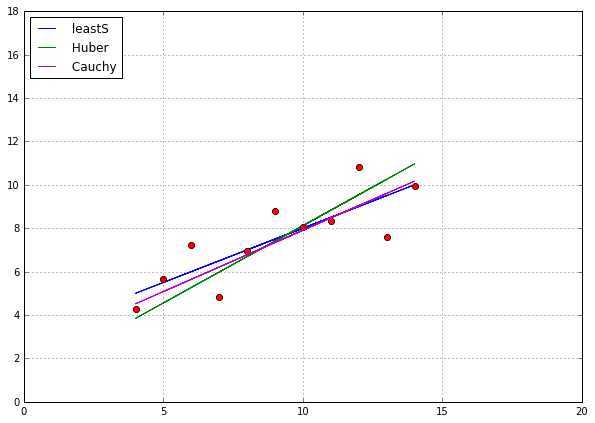

In [24]:
plt.figure(figsize = [10, 7])
plot(leastSquare, ds1, col="b")
plot(Huber, ds1, col="g")
plot(Cauchy, ds1, col="m")

LS: b: [ 3.00090909  0.5       ] | LS Error 10.647273

Huber: Iteration 4 | b: [ 0.99720301  0.73880457] 
Huber Error: 7.221296 |LS Error:11.773931

Cauchy: Iteration 64 | b: [ 1.47775251  0.70694134]  
Cauchy Error: 3.907309 | Huber Error: 6.837367 | LS Error:11.291423


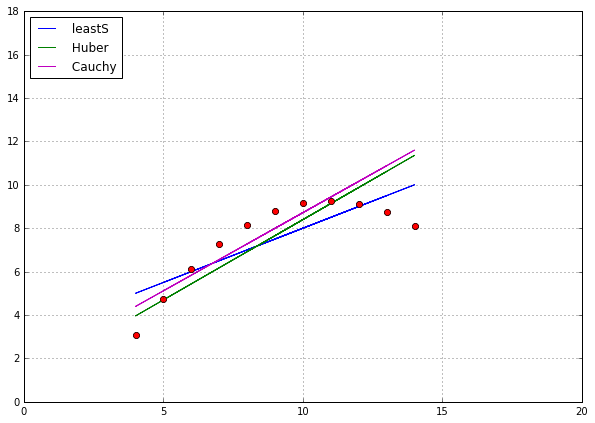

In [25]:
plt.figure(figsize = [10, 7])
plot(leastSquare, ds2, col="b")
plot(Huber, ds2, col="g")
plot(Cauchy, ds2, col="m")

LS: b: [ 3.00245455  0.49972727] | LS Error 7.875636

Huber: Iteration 1 | b: [ 0.9965625  0.6903125] 
Huber Error: 7.190031 |LS Error:11.737500

Cauchy: Iteration 506 | b: [ 3.55625451  0.39686255]  
Cauchy Error: 1.542166 | Huber Error: 3.647202 | LS Error:5.362959


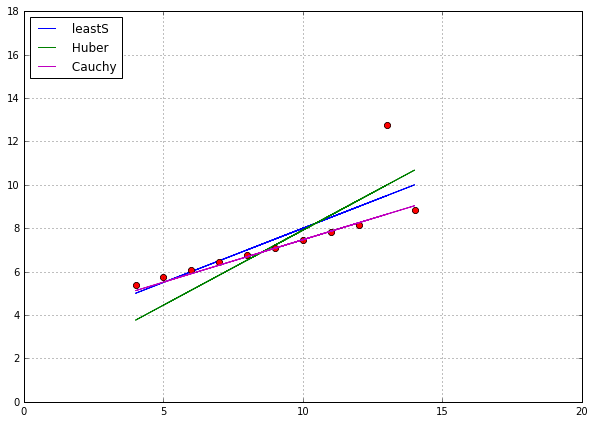

In [26]:
plt.figure(figsize = [10, 7])
plot(leastSquare, ds3, col="b")
plot(Huber, ds3, col="g")
plot(Cauchy, ds3, col="m")

LS: b: [ 3.00172727  0.49990909] | LS Error 9.930000

Huber: Iteration 2 | b: [ 0.99650231  0.69025231] 
Huber Error: 7.689650 |LS Error:12.407213

Cauchy: Iteration 145 | b: [ 2.11357937  0.56420667]  
Cauchy Error: 3.860093 | Huber Error: 6.418021 | LS Error:10.789041


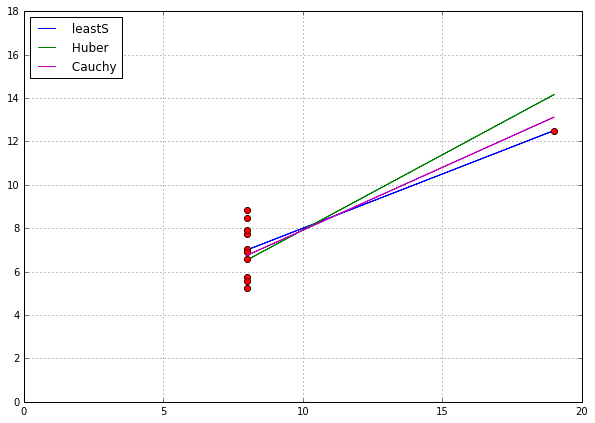

In [27]:
plt.figure(figsize = [10, 7])
plot(leastSquare, ds4, col="b")
plot(Huber, ds4, col="g")
plot(Cauchy, ds4, col="m")